<img src="images/oasis-lmf-colour.png" alt="Oasis LMF logo" width="250" align="left"/>
<br><br><br>

# Excercise 2:   Introduction to Oasis model files and formats.

The Oasis kernel provides a robust loss simulation engine for catastrophe modelling. Insurance practitioners are used to dealing with losses arising from events. These losses are numbers, not distributions. Policy terms are applied to the losses individually and then aggregated and further conditions or reinsurances applied. Oasis takes the same perspective, which is to generate individual losses from the probability distributions. The way to achieve this is random sampling called “Monte-Carlo” sampling from the use of random numbers, as if from a roulette wheel, to solve equations that are otherwise intractable.

Modelled and empirical intensities and damage responses can show significant uncertainty, Sometimes this uncertainty is multi-modal, meaning that there can be different peaks of behaviour rather than just a single central behaviour. Moreover, the definition of the source insured interest characteristics, such as location or occupancy or construction, can be imprecise. The associated values for event intensities and consequential damages can therefore be varied and their uncertainty can be represented in general as probability distributions rather than point values. The design of Oasis therefore makes no assumptions about the probability distributions and instead treats all probability distributions as probability masses in discrete bins. This includes closed interval point bins such as the values [0,0] for no damage and [1,1] for total damage.

The simulation approach taken by the Oasis calculation kernel computes a single cumulative distribution function (CDF) for the damage by “convolving” the binned intensity distribution with the vulnerability matrices. Sampling can then be done against the CDF. 

<img src="images/simulation_methodology.png" alt="Oasis simulation methodology" width="600"/>

The Oasis kernel requires a standard set of files for capturing the hazard footprints and vulnerability data.

<img src="images/oasis_model_files.png" alt="Oasis model files" width="600"/>

The files are:

#### area peril dictionary
    The meta-data that describes the model specific geo-spatial grid. This can be a set of points, a regular grid or a variable resolutiuon grid.
#### intensity bin dictionary
    The meta-data that descibes the hazard intensities corresponding to the bins.
#### hazard
    The hazard values for each impacted area peril cell for each event in the stochastic catalogue.
#### damage bin dictionary
    The meta-data tha descibes the damage percentages corresponding to the bins.
#### vulnerability dictionary
    The meta-data that descibes the vulnerability data, in particular mapping particular curves to particular exposure attributes.
#### vulnerability
    The vulnerability data. 
#### event
    The list of events in the stochastic catalogue. Event files can be use to distinguish event types, such as historical.
#### occurrences
    The list of event occurrences in particular periods, used for loss curve calculations.

## Example model
For the excercises, we are using a cut-down version of the Catrisks' Middle East Earthquake model. We include the full catalogue of events, but only for an area around the city of Beirut. The intensity bins dictionary only includes "hazard levels" and not actual PGA values, protecting the Catrisk IP in the example. The intensity levels are not required for loss calculations, which only depend on the event hazard getting linked to the correct damage level. This model contains both hazard and damage uncertainty.


## Excercise goals
* Understand the Oasis model files
* Use Python code to view the model files for an example model
* Use Python code to visualise run and view the results of an analysis


In [5]:
%config IPCompleter.greedy=True

In [6]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import math
import numpy as np
import json
import seaborn as sns
import folium
import os
from shapely.geometry import Point, Polygon
from numpy import linspace
from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource, FixedTicker, PrintfTickFormatter
from bokeh.plotting import figure
import branca.colormap as cm
import datetime

# Output Bokeh charts to notebook, rather than opening a browser window
output_notebook()

Loading BokehJS ...

## View the model files

### Area peril dictionary

In [7]:
area_peril_dictionary = pd.read_csv("./keys_data/MEEQ/area_peril_dict.csv")
area_peril_dictionary.head()

,area_peril_id,longitude,latitude
0,1005275201,35.4500,33.7167
1,1005274201,35.5167,33.7167
2,1005258001,35.4542,33.7292
3,1005257901,35.4542,33.7375
4,1005254601,35.5208,33.7375


In [8]:
m = folium.Map(location=[	33.85, 35.50], zoom_start=12, tiles='cartodbpositron')
for i, row in area_peril_dictionary.iterrows():
    folium.CircleMarker(
        location=[row.latitude, row.longitude], radius=1).add_to(m)
m.fit_bounds(m.get_bounds())
m

### Intensity bin dictionary

In [9]:
intensity_bin_dictionary = pd.read_csv("./model_data/MEEQ/intensity_bin_dict.csv")
intensity_bin_dictionary.head()

,bin_id,bin_from,bin_to,interpolation,interval_type
0,1,1,1,1,1201
1,2,2,2,2,1201
2,3,3,3,3,1201
3,4,4,4,4,1201
4,5,5,5,5,1201


### Hazard

In [10]:
footprints = pd.read_csv("./model_data/MEEQ/footprint_subset.csv")
footprints.head()

,event_id,area_peril_id,intensity_bin_id,probability
0,3342,1005237101,1,0.968867
1,3342,1005237101,2,0.008444
2,3342,1005237101,3,0.006488
3,3342,1005237101,4,0.004874
4,3342,1005237101,5,0.003579


In [11]:
event_id = 40897
#event_id = 199482

area_peril_id = 1005237101

In [12]:
footprints_with_hazard = footprints.merge(
    area_peril_dictionary, how='inner', 
    on='area_peril_id').merge(
    intensity_bin_dictionary, how="inner",
    left_on="intensity_bin_id", right_on="bin_id")
footprint_with_hazard = footprints_with_hazard[footprints_with_hazard.event_id == event_id]
footprint_with_hazard = footprint_with_hazard[['area_peril_id', 'latitude', 'longitude', 'probability', 'intensity_bin_id','interpolation']] 
footprint_with_hazard = footprint_with_hazard.sort_values(['area_peril_id'])
footprint_with_hazard = footprint_with_hazard.rename(index=str, columns={"interpolation": "hazard"})
footprint_with_hazard.head()

,area_peril_id,latitude,longitude,probability,intensity_bin_id,hazard
32,1005237101,33.9042,35.4958,0.042672,1,1
1062122,1005237101,33.9042,35.4958,0.004195,27,27
322894,1005237101,33.9042,35.4958,0.018223,3,3
1059934,1005237101,33.9042,35.4958,0.006287,26,26
416712,1005237101,33.9042,35.4958,0.022626,4,4


In [13]:
footprint_with_hazard_for_cell = footprint_with_hazard[footprint_with_hazard.area_peril_id == area_peril_id] 
footprint_with_hazard_for_cell = intensity_bin_dictionary.merge(
    footprint_with_hazard_for_cell, how="left",
    left_on="bin_id", right_on="intensity_bin_id", suffixes=('', '_dict'))

footprint_with_hazard_for_cell.fillna(0)
footprint_with_hazard_for_cell = footprint_with_hazard_for_cell.sort_values("intensity_bin_id")
footprint_with_hazard_for_cell = footprint_with_hazard_for_cell[['probability', 'intensity_bin_id','interpolation']]
footprint_with_hazard_for_cell = footprint_with_hazard_for_cell.rename(index=str, columns={"interpolation": "hazard"})
footprint_with_hazard_for_cell.head()

,probability,intensity_bin_id,hazard
0,0.042672,1.0,1
1,0.014415,2.0,2
2,0.018223,3.0,3
3,0.022626,4.0,4
4,0.027574,5.0,5


In [14]:
footprint_with_hazard['weighted_hazard'] = footprint_with_hazard['hazard'] * footprint_with_hazard['probability'] 
footprint_with_mean_hazard = pd.DataFrame({'mean_hazard' : footprint_with_hazard.groupby( ['area_peril_id', 'latitude', 'longitude'] )['weighted_hazard'].sum()}).reset_index()

linear = cm.LinearColormap(
    ['green', 'yellow', 'red'],
    vmin=min(footprint_with_mean_hazard.mean_hazard), 
    vmax=max(footprint_with_mean_hazard.mean_hazard))
m = folium.Map(location=[33.85, 35.50], zoom_start=12, tiles='cartodbpositron')
for i, row in footprint_with_mean_hazard.iterrows():
    c = linear(row.mean_hazard)
    folium.CircleMarker(
        location=[row.latitude, row.longitude], fill_color=c, radius=5,
        weight=0, fill=True, fill_opacity=1.0).add_to(m)
linear.caption = 'Hazard'
m.add_child(linear)
m.fit_bounds(m.get_bounds())
m

In [15]:
intensity_range = list([str(i) for i in intensity_bin_dictionary.bin_id])
p = figure(x_range=intensity_range, plot_height=300, y_range=(0, footprint_with_hazard_for_cell.probability.max()), toolbar_location=None)
p.vbar(x=footprint_with_hazard_for_cell.hazard, top=footprint_with_hazard_for_cell.probability, width=0.9)
p.xaxis.axis_label = 'Hazard bin'
p.yaxis.axis_label = 'Probability'
show(p)

### Damage bin dictionary

In [16]:
damage_bin_dictionary = pd.read_csv("./model_data/MEEQ/damage_bin_dict.csv")
damage_bin_dictionary.head()

,bin_id,bin_from,bin_to,interpolation,interval_type
0,1,0.000,0.000,0.0000,1201
1,2,0.000,0.001,0.0005,1201
2,3,0.001,0.020,0.0105,1201
3,4,0.020,0.040,0.0300,1201
4,5,0.040,0.060,0.0500,1201


### Vulnerability dictionary

In [17]:
vulnerability_dict = pd.read_csv("./keys_data/MEEQ/vulnerability_dict.csv")
vulnerability_dict.head()

,VULNERABILITY_ID,COVERAGE,BLDGSCHEME,BLDGCLASS
0,712,1,RMS,1
1,713,1,RMS,1A
2,714,1,RMS,1A1
3,714,1,RMS,1A2
4,714,1,RMS,1A3


### Vulnerability

In [18]:
vulnerabilities = pd.read_csv("./model_data/MEEQ/vulnerability_subset.csv")
vulnerabilities.head(10)

,vulnerability_id,intensity_bin_id,damage_bin_id,probability
0,712,1,1,1.000000
1,712,2,1,1.000000
2,712,3,2,0.516807
3,712,3,3,0.464853
4,712,3,4,0.013151
5,712,3,5,0.005189
6,712,4,2,0.537729
7,712,4,3,0.428384
8,712,4,4,0.020920
9,712,4,5,0.006051


In [19]:
vulnerability_id = 713

def joy(category, data, scale=1):
    return list(zip([category]*len(data), scale*data))

num_intensity_bins = len(intensity_bin_dictionary.bin_id)
num_damage_bins = len(damage_bin_dictionary.bin_id)

z = linspace(0, 100, num_damage_bins+1)
x = np.delete(z, num_damage_bins)
x = np.insert(x, 0, -1.5)


intensity_range = list([str(i) for i in intensity_bin_dictionary.bin_id])

p = figure(y_range=intensity_range, plot_width=900, x_range=(0, 105), toolbar_location=None)


data = vulnerabilities[vulnerabilities.vulnerability_id==vulnerability_id]

for i, intensity_bin_id in enumerate(reversed(intensity_range)):        
    all_damage_bins=pd.DataFrame({"damage_bin_id": list(range(0,num_damage_bins+1))})
    d = all_damage_bins.merge(data[data.intensity_bin_id==int(intensity_bin_id)], on="damage_bin_id", how="outer")
    d = d.fillna(0)
           
    y = joy(intensity_bin_id, d.probability, 10)

    top =[]
    for i in range(len(y)):
        top.append((y[i][1])+int(y[i][0])-0.5)
    bottom = []
    for i in range(len(y)):
        bottom.append(int(y[i][0])-0.5)
 
    p.quad(left=x, right=z, top=top, bottom=bottom, alpha = 0.6)


p.outline_line_color = "black"
p.background_fill_color = "#efefef"

p.xaxis.ticker = FixedTicker(ticks=list(range(0, 105, 10)))
p.xaxis.formatter = PrintfTickFormatter(format="%d%%")

p.ygrid.grid_line_color = None
p.xgrid.grid_line_color = "#dddddd"
p.xgrid.ticker = p.xaxis[0].ticker

p.axis.minor_tick_line_color = None
p.axis.major_tick_line_color = None
p.axis.axis_line_color = None

p.xaxis.axis_label = 'Damage'
p.yaxis.axis_label = 'Hazard'

p.y_range.range_padding = 0.12
show(p)

### Occurrence file

In [20]:
occurrences = pd.read_csv("./model_data/MEEQ/occurrence.csv")
occurrences.head()

,event_id,period_no,occ_date_id
0,76,2,4291251
1,131,2,11150352
2,136,2,12080311
3,139,2,12120355
4,141,2,12211623


## Model execution

To run the model we need some test exxposure data. Lets have a look at an example Location and Account file. 

In [21]:
test_locations = pd.read_csv('./source_data/Beirut_EQ_loc.csv')
test_locations.head()


,ACCNTNUM,LOCNUM,LATITUDE,LONGITUDE,POSTCODE,ADDRMATCH,STATE,STATECODE,COUNTY,COUNTYCODE,...,EQSITEDED,EQSITEDCUR,EQCOMBINEDLIM,EQCOMBINEDLCUR,EQCOMBINEDDED,EQCOMBINEDDCUR,COND1TYPE,COND1NAME,COND1LIMIT,COND1DEDUCTIBLE
0,11111,2,33.88894,35.49442,XXX,0,0,0,0,0,...,0,USD,0,USD,0,USD,XXX,XXX,0,0
1,11111,3,33.71670,35.45000,XXX,0,0,0,0,0,...,0,USD,0,USD,0,USD,XXX,XXX,0,0
2,11111,4,33.71670,35.51670,XXX,0,0,0,0,0,...,0,USD,0,USD,0,USD,XXX,XXX,0,0
3,11111,5,33.72920,35.45420,XXX,0,0,0,0,0,...,0,USD,0,USD,0,USD,XXX,XXX,0,0
4,11111,6,33.73750,35.45420,XXX,0,0,0,0,0,...,0,USD,0,USD,0,USD,XXX,XXX,0,0


To run the model, we also need to define some analysis settings. Lets have a look at an example settings file.

In [22]:
with open('./analysis_settings.json', 'r') as myfile:
    analysis_settings=json.loads(myfile.read().replace('\n', ''))
print(json.dumps(analysis_settings, indent=True))

{
 "analysis_settings": {
  "gul_summaries": [
   {
    "leccalc": {
     "outputs": {
      "full_uncertainty_aep": true, 
      "full_uncertainty_oep": true
     }, 
     "return_period_file": true
    }, 
    "lec_output": true, 
    "eltcalc": true, 
    "aalcalc": true, 
    "id": 1
   }
  ], 
  "source_tag": "MEEQ", 
  "il_summaries": [], 
  "analysis_tag": 1, 
  "number_of_samples": 10, 
  "model_version_id": "MEEQ", 
  "module_supplier_id": "Catrisks", 
  "gul_threshold": 0, 
  "gul_output": true, 
  "model_settings": {
   "event_set": "", 
   "event_occurrence_id": ""
  }
 }
}


In [23]:
! damagebintobin < ./model_data/MEEQ/damage_bin_dict.csv > ./model_data/MEEQ/damage_bin_dict.bin 
! evetobin < ./model_data/MEEQ/events_subset.csv > ./model_data/MEEQ/events.bin
! vulnerabilitytobin -d 52 < ./model_data/MEEQ/vulnerability_subset.csv > ./model_data/MEEQ/vulnerability.bin
! footprinttobin -i 30 < ./model_data/MEEQ/footprint_subset.csv
! occurrencetobin -P 10000 -D < ./model_data/MEEQ/occurrence.csv > ./model_data/MEEQ/occurrence.bin
! returnperiodtobin < ./model_data/MEEQ/returnperiods.csv  > ./model_data/MEEQ/returnperiods.bin

starting...
done...


In [24]:
! rm -rf /tmp/analysis_test
! oasislmf model run -C oasislmf.json -r /tmp/analysis_test


Creating temporary folder /tmp/analysis_test/tmp for Oasis files

Getting model info and lookup
STARTED: oasislmf.keys.lookup.__init__
STARTED: oasislmf.keys.lookup.__init__
COMPLETED: oasislmf.keys.lookup.__init__ in 0.0s
STARTED: oasislmf.keys.lookup.__init__
STARTED: oasislmf.keys.lookup.__init__
COMPLETED: oasislmf.keys.lookup.__init__ in 0.0s
COMPLETED: oasislmf.keys.lookup.__init__ in 0.01s
STARTED: oasislmf.keys.lookup.__init__
STARTED: oasislmf.keys.lookup.__init__
COMPLETED: oasislmf.keys.lookup.__init__ in 0.0s
STARTED: oasislmf.keys.lookup.get_vulnerabilities
COMPLETED: oasislmf.keys.lookup.get_vulnerabilities in 0.04s
COMPLETED: oasislmf.keys.lookup.__init__ in 0.04s
COMPLETED: oasislmf.keys.lookup.__init__ in 0.05s
	{u'model_version': u'0.0.0.1', u'model_id': u'MEEQ', u'supplier_id': u'Catrisks'}, <oasislmf.keys.lookup.OasisLookup object at 0x7fdfa10711d0>

Creating Oasis model object
	<class 'oasislmf.models.model.OasisModel'>: {'_key': u'Catrisks/MEEQ/0.0.0.1', '_suppli


Converting Oasis files to ktools binary files

Reading analysis settings JSON file

Loaded analysis settings JSON: {u'gul_summaries': [{u'leccalc': {u'outputs': {u'full_uncertainty_aep': True, u'full_uncertainty_oep': True}, u'return_period_file': True}, u'lec_output': True, u'eltcalc': True, u'aalcalc': True, u'id': 1}], u'source_tag': u'MEEQ', u'il_summaries': [], u'analysis_tag': 1, u'number_of_samples': 10, u'model_version_id': u'MEEQ', u'module_supplier_id': u'Catrisks', u'gul_threshold': 0, u'gul_output': True, u'model_settings': {u'event_set': u'', u'event_occurrence_id': u''}}

Preparing model run inputs
STARTED: oasislmf.model_execution.runner.run
COMPLETED: oasislmf.model_execution.runner.run in 2.85s

Loss outputs generated in /tmp/analysis_test/output


In [25]:
! cp /tmp/analysis_test/tmp/canexp* /tmp/analysis_test/tmp/canexp.csv
! cp /tmp/analysis_test/tmp/oasiskeys-2* /tmp/analysis_test/tmp/oasiskeys.csv
! cp /tmp/analysis_test/tmp/oasiskeys-e* /tmp/analysis_test/tmp/oasiskeyserrors.csv

In [26]:
analysis_directory = "/tmp/analysis_test"

all_dictionary = pd.read_csv(os.path.join(analysis_directory, "tmp", "canexp.csv"))
all_dictionary.head()

,ROW_ID,ACCNTNUM,LOCNUM,LATITUDE,LONGITUDE,POSTCODE,ADDRMATCH,STATE,STATECODE,COUNTY,...,EQSITEDED,EQSITEDCUR,EQCOMBINEDLIM,EQCOMBINEDLCUR,EQCOMBINEDDED,EQCOMBINEDDCUR,COND1TYPE,COND1NAME,COND1LIMIT,COND1DEDUCTIBLE
0,1,11111,2,33.88894,35.49442,XXX,0,0,0,0,...,0,USD,0,USD,0,USD,XXX,XXX,0,0
1,2,11111,3,33.71670,35.45000,XXX,0,0,0,0,...,0,USD,0,USD,0,USD,XXX,XXX,0,0
2,3,11111,4,33.71670,35.51670,XXX,0,0,0,0,...,0,USD,0,USD,0,USD,XXX,XXX,0,0
3,4,11111,5,33.72920,35.45420,XXX,0,0,0,0,...,0,USD,0,USD,0,USD,XXX,XXX,0,0
4,5,11111,6,33.73750,35.45420,XXX,0,0,0,0,...,0,USD,0,USD,0,USD,XXX,XXX,0,0


## Incomplete data

Some accounts may be missing necessary data. The errors are found in a separate oasiskeys-errors file with the error message.

In [27]:
success_dictionary = pd.read_csv(os.path.join(analysis_directory, "tmp", "oasiskeys.csv"))
success_dictionary.head()

,LocID,PerilID,CoverageID,AreaPerilID,VulnerabilityID
0,1,3,1,1005238401,713
1,2,3,1,1005275201,713
2,3,3,1,1005274201,713
3,4,3,1,1005258001,713
4,5,3,1,1005257901,713


In [28]:
failure_dictionary = pd.read_csv(os.path.join(analysis_directory, "tmp", "oasiskeyserrors.csv"))
failure_dictionary.head()

,LocID,PerilID,CoverageID,Message
0,24,3,1,Successful peril area lookup: 1005267401; No v...
1,34,3,1,Successful peril area lookup: 1005253801; No v...
2,44,3,1,Successful peril area lookup: 1005257701; No v...
3,51,3,1,Successful peril area lookup: 1005256901; No v...
4,59,3,1,Successful peril area lookup: 1005255901; No v...


In [29]:
m = folium.Map(location=[	33.85, 35.50], zoom_start=12, tiles='cartodbpositron')

#Red for errors, blue for success

for i, row in failure_dictionary.iterrows():
    loc = failure_dictionary.at[i, 'LocID'] - 1
    lat = all_dictionary.loc[loc, 'LATITUDE']
    lon = all_dictionary.loc[loc, 'LONGITUDE']
    folium.CircleMarker(
        location=[lat, lon], radius=1, color='red').add_to(m)

for i, row in success_dictionary.iterrows():
    loc = success_dictionary.at[i, 'LocID'] - 1
    lat = all_dictionary.loc[loc, 'LATITUDE']
    lon = all_dictionary.loc[loc, 'LONGITUDE']
    folium.CircleMarker(
        location=[lat, lon], radius=1).add_to(m)
m.fit_bounds(m.get_bounds())
m

In [30]:
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.transform import factor_cmap

analysis_directory = "/tmp/analysis_test"
gul_aep = pd.read_csv(os.path.join(analysis_directory, "output", "gul_S1_leccalc_full_uncertainty_aep.csv"))
gul_oep = pd.read_csv(os.path.join(analysis_directory, "output", "gul_S1_leccalc_full_uncertainty_oep.csv"))
eps = pd.merge(gul_oep, gul_aep, on=["summary_id", "return_period"], suffixes=["_oep", "_aep"])
eps = eps.sort_values(by="return_period", ascending=True)
return_periods = eps.return_period
lec_types = ['OEP', 'AEP']
data = {'Return periods' : return_periods,
       'OEP': eps.loss_oep,
       'AEP': eps.loss_aep}
palette = ["#c9d9d3", "#718dbf"]
x = [ (str(return_period), lec_type) for return_period in return_periods for lec_type in lec_types ]
counts = sum(zip(data['OEP'], data['AEP']), ())
source = ColumnDataSource(data=dict(x=x, counts=counts))
p = figure(x_range=FactorRange(*x), plot_height=350, title="EP by return period",
          toolbar_location=None, tools="")
p.vbar(x='x', top='counts', width=0.9, source=source, line_color="white",
      fill_color=factor_cmap('x', palette=palette, factors=lec_types, start=1, end=2))
p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None
show(p)

In [31]:
! more /tmp/analysis_test/output/gul_S1_aalcalc.csv

summary_id,type,mean,standard_deviation,exposure_value
1,1,62890.997792,917495.434976,104982168.000000
1,2,62856.590769,919611.672947,104982168.000000


## Event meta-data

In [32]:
event_data = pd.read_csv("./model_data/MEEQ/event_details.csv")
event_data.rename(columns={'FID':'event_id'}, inplace=True)
event_data.head()

,event_id,Mag,StrikAzimu,DipAngle,Depth,Date_10000,Ev_ID
0,2,4.748,"-9,999.00","-9,999.00",12.469,10112,0
1,6,5.230,237.788,70,12.751,10322,0
2,7,5.242,114.213,90,9.675,10325,0
3,8,4.767,47.623,70,10.015,10404,0
4,9,4.966,67.262,70,13.129,10408,0


In [33]:
gul_elt = pd.read_csv(os.path.join("/tmp/analysis_test", "output", "gul_S1_eltcalc.csv"))
gul_elt.head()

,summary_id,type,event_id,mean,standard_deviation,exposure_value
0,1,1,1000503,0.000000,0.000000,4159454.0
1,1,2,1000503,0.000000,0.000000,4159454.0
2,1,1,1000571,1602.963623,0.000000,89579984.0
3,1,2,1000571,11818.318359,23071.738281,89579984.0
4,1,1,1000620,796435.812500,0.000000,104982168.0


In [34]:
loss_event_dict = gul_elt.loc[::2,['event_id', 'exposure_value']]
loss_event_dict.head()

,event_id,exposure_value
0,1000503,4159454.0
2,1000571,89579984.0
4,1000620,104982168.0
6,1001816,97167816.0
8,1003196,98503832.0


In [35]:
loss_event_detail = pd.merge(loss_event_dict, event_data, on = 'event_id')
loss_event_detail= loss_event_detail.sort_values(by='Date_10000')
loss_event_detail.head()

,event_id,exposure_value,Mag,StrikAzimu,DipAngle,Depth,Date_10000,Ev_ID
73,4391,5648976.0,5.062,60.641,70,12.632,430806,0
3,10762,40161732.0,4.884,"-9,999.00","-9,999.00",8.968,1040403,0
16,15046,104982168.0,6.474,"-9,999.00","-9,999.00",10.726,1451024,0
69,42706,89883128.0,5.164,114.021,70,17.651,4130725,0
72,43257,104982168.0,5.514,219.888,90,15.899,4181130,0


In [78]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 20)

Populating the interactive namespace from numpy and matplotlib


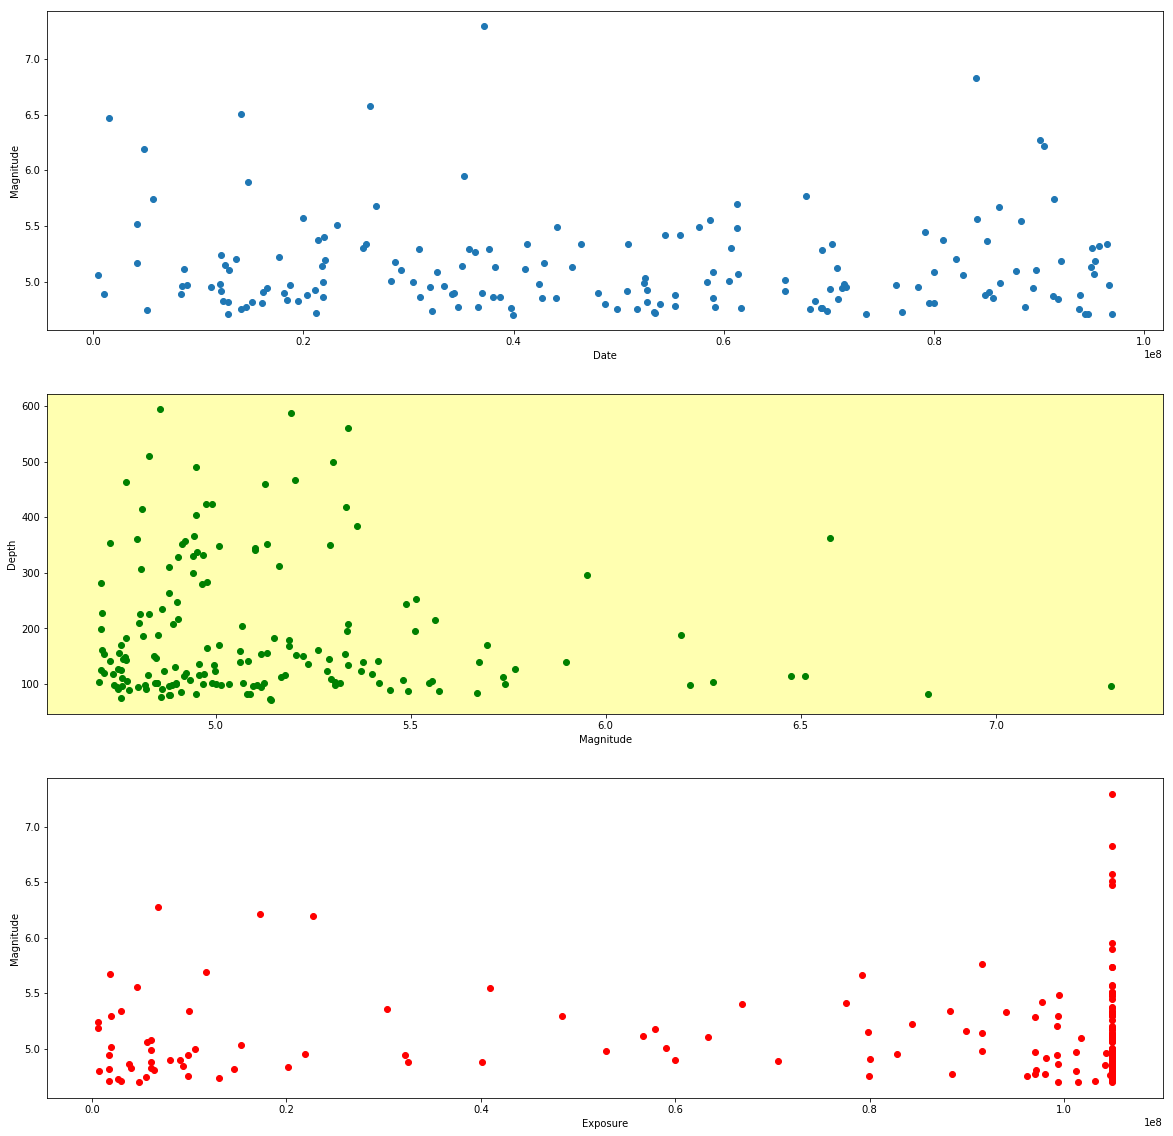

In [92]:
exposure = list(loss_event_detail['exposure_value'])
date = list(loss_event_detail['Date_10000'])
magnitude = list(loss_event_detail['Mag'])
depth = list(loss_event_detail['Depth'])
depth = [d**2 for d in depth]
plt.subplot(311)
plt.scatter(date, magnitude)
plt.xlabel('Date')
plt.ylabel('Magnitude')

plt.subplot(313)
plt.scatter(exposure, magnitude, color='red')
plt.xlabel('Exposure')
plt.ylabel('Magnitude')

plt.subplot(312, facecolor='#FFFFB0')
plt.scatter(magnitude, depth, color = 'green')
plt.xlabel('Magnitude')
plt.ylabel('Depth')



plt.show()